In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.model_selection import GridSearchCV

np.random.seed(42)

In [46]:
# 1. load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target

# convert to NumPy array and normalize
X = np.array(X) / 255.0
y = np.array(y).astype(int)

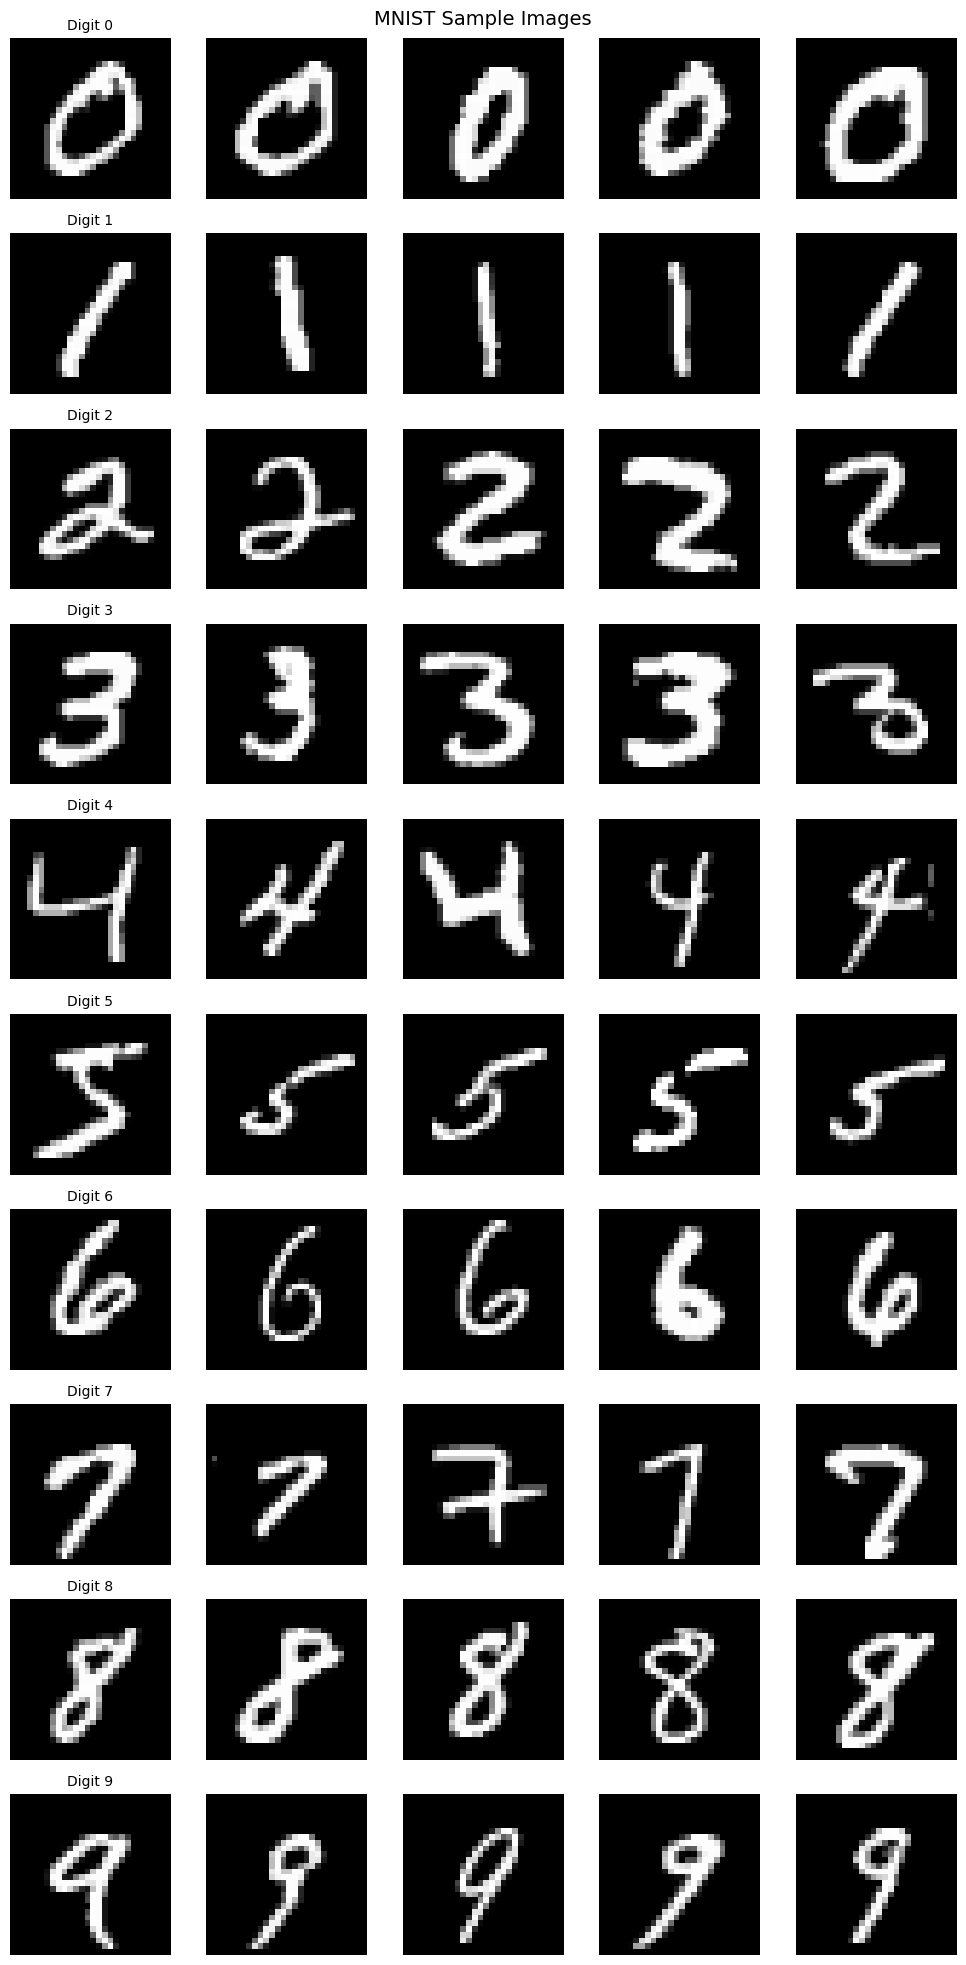

In [47]:
# 2. data visualization
fig, axes = plt.subplots(10, 5, figsize=(10, 20))

for digit in range(10):
    # Select the first 5 images
    samples = X[y == digit][:5]
    for j, s in enumerate(samples):
        axes[digit, j].imshow(s.reshape(28, 28), cmap='gray')
        axes[digit, j].axis('off')
        if j == 0:
            axes[digit, j].set_title(f'Digit {digit}', fontsize=10)

plt.suptitle('MNIST Sample Images', fontsize=14)
plt.tight_layout()
plt.savefig('mnist_sample_images.png', dpi=150)
plt.show()

In [48]:
# 3. pca

# different dimensions as hyperparameters
dim = [50, 75, 100]
pca_results = {}

for d in dim:
    pca = PCA(n_components=d, random_state=42)
    X_pca = pca.fit_transform(X)
    pca_results[d] = {
        'X_pca': X_pca,
        'explained_variance': np.sum(pca.explained_variance_ratio_)
    }
    print(f"PCA reduced to {d} dimensions, variance retained: {pca_results[d]['explained_variance']:.4f}")

PCA reduced to 50 dimensions, variance retained: 0.8254
PCA reduced to 75 dimensions, variance retained: 0.8833
PCA reduced to 100 dimensions, variance retained: 0.9150


In [49]:
# select 100d for clustering
X_reduced = pca_results[100]['X_pca']

In [50]:
# 4. k-means

# hyperparameter 1: Number of clusters
# hyperparameter 2: Initialization method
kmeans_params = {
    'n_clusters': [4, 8, 10, 12, 15],
    'init': ['k-means++', 'random'],
    'n_init': [10],
    'max_iter': [300],
    'random_state': [42]
}

kmeans_results = []

for k in kmeans_params['n_clusters']:
    for init_method in kmeans_params['init']:
        kmeans = KMeans(
            n_clusters=k,
            init=init_method,
            n_init=10,
            max_iter=300,
            random_state=42
        )
        labels_pred = kmeans.fit_predict(X_reduced)
        
        # evaluation metrics
        ari = adjusted_rand_score(y, labels_pred)
        nmi = normalized_mutual_info_score(y, labels_pred)
        sil = silhouette_score(X_reduced, labels_pred, sample_size=5000)
        
        kmeans_results.append({
            'n_clusters': k,
            'init': init_method,
            'ARI': ari,
            'NMI': nmi,
            'Silhouette': sil,
            'model': kmeans,
            'labels': labels_pred
        })
        
        print(f"K={k}, init={init_method}: ARI={ari:.4f}, NMI={nmi:.4f}, Silhouette={sil:.4f}")

K=4, init=k-means++: ARI=0.2562, NMI=0.3793, Silhouette=0.0678
K=4, init=random: ARI=0.2557, NMI=0.3788, Silhouette=0.0658
K=8, init=k-means++: ARI=0.3959, NMI=0.5061, Silhouette=0.0846
K=8, init=random: ARI=0.3959, NMI=0.5061, Silhouette=0.0843
K=10, init=k-means++: ARI=0.3665, NMI=0.4997, Silhouette=0.0732
K=10, init=random: ARI=0.3662, NMI=0.4994, Silhouette=0.0730
K=12, init=k-means++: ARI=0.3517, NMI=0.5023, Silhouette=0.0703
K=12, init=random: ARI=0.3445, NMI=0.4938, Silhouette=0.0692
K=15, init=k-means++: ARI=0.3795, NMI=0.5371, Silhouette=0.0750
K=15, init=random: ARI=0.3780, NMI=0.5359, Silhouette=0.0764


In [51]:
# best kmeans with NMI
best_kmeans = max(kmeans_results, key=lambda x: x['NMI'])
print(f"Best configuration: K={best_kmeans['n_clusters']}, init={best_kmeans['init']}")
print(f"Best performance: ARI={best_kmeans['ARI']:.4f}, NMI={best_kmeans['NMI']:.4f}, Silhouette={best_kmeans['Silhouette']:.4f}")

Best configuration: K=15, init=k-means++
Best performance: ARI=0.3795, NMI=0.5371, Silhouette=0.0750


In [52]:
# 5. gmm

# hyperparameter 1: number of components
# hyperparameter 2: covariance_type

gmm_param_grid = {
    'n_components': [8, 10, 12, 15],
    'covariance_type': ['full', 'tied', 'diag']
}

# cross validation
gmm = GaussianMixture(max_iter=100, random_state=42)

gmm_cv = GridSearchCV(
    estimator=gmm,
    param_grid=gmm_param_grid,
    cv=3,
    verbose=2,
    n_jobs=-1
)

gmm_cv.fit(X_reduced)

print(f"Best GMM parameters : {gmm_cv.best_params_}")
print(f"Best GMM CV score : {gmm_cv.best_score_:.4f}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[CV] END ...............covariance_type=full, n_components=8; total time= 1.9min
[CV] END ...............covariance_type=full, n_components=8; total time= 2.2min
[CV] END ...............covariance_type=full, n_components=8; total time= 2.3min
[CV] END ..............covariance_type=full, n_components=10; total time= 2.4min
[CV] END ..............covariance_type=full, n_components=10; total time= 2.6min
[CV] END ..............covariance_type=full, n_components=12; total time= 2.7min
[CV] END ..............covariance_type=full, n_components=10; total time= 2.7min
[CV] END ..............covariance_type=full, n_components=12; total time= 3.0min
[CV] END ...............covariance_type=tied, n_components=8; total time=  37.4s
[CV] END ...............covariance_type=tied, n_components=8; total time=  44.6s
[CV] END ...............covariance_type=tied, n_components=8; total time=  49.3s
[CV] END ..............covariance_type=tied, n_components=10; total time=  55.5s
[CV] END ..............covar

In [53]:
# best gmm
best_gmm_model = gmm_cv.best_estimator_
best_gmm_labels = best_gmm_model.predict(X_reduced)

# evaluation metrics
gmm_ari = adjusted_rand_score(y, best_gmm_labels)
gmm_nmi = normalized_mutual_info_score(y, best_gmm_labels)
gmm_sil = silhouette_score(X_reduced, best_gmm_labels, sample_size=5000)

print(f"Best GMM Performance Metrics:")
print(f"ARI: {gmm_ari:.4f}")
print(f"NMI: {gmm_nmi:.4f}")
print(f"Silhouette Score: {gmm_sil:.4f}")

Best GMM Performance Metrics:
ARI: 0.3535
NMI: 0.5552
Silhouette Score: 0.0103


In [54]:
# save best gmm
best_gmm = {
    'n_components': gmm_cv.best_params_['n_components'],
    'covariance_type': gmm_cv.best_params_['covariance_type'],
    'ARI': gmm_ari,
    'NMI': gmm_nmi,
    'Silhouette': gmm_sil,
    'model': best_gmm_model,
    'labels': best_gmm_labels,
    'cv_score': gmm_cv.best_score_
}

In [55]:
#6. performance

# Top 5
gmm_top5 = []
sorted_indices = np.argsort(gmm_cv.cv_results_['rank_test_score'])[:5]
for idx in sorted_indices:
    params = gmm_cv.cv_results_['params'][idx]
    gmm_top5.append({
        'Rank': gmm_cv.cv_results_['rank_test_score'][idx],
        'n_components': params['n_components'],
        'covariance_type': params['covariance_type'],
        'Mean_CV_Score': gmm_cv.cv_results_['mean_test_score'][idx],
        'Std_CV_Score': gmm_cv.cv_results_['std_test_score'][idx]
    })
gmm_top5_df = pd.DataFrame(gmm_top5)
gmm_top5_df

,Rank,n_components,covariance_type,Mean_CV_Score,Std_CV_Score
0,1,15,full,2.460980,0.277093
1,2,12,full,-2.092197,0.368004
2,3,10,full,-6.398596,0.232035
3,4,8,full,-13.045537,0.898610
4,5,15,diag,-59.167973,0.139397


In [56]:
kmeans_top5 = sorted(kmeans_results, key=lambda x: x['NMI'], reverse=True)[:5]
kmeans_top5_df = pd.DataFrame([{
    'Rank': i+1,
    'K': r['n_clusters'],
    'Init': r['init'],
    'ARI': r['ARI'],
    'NMI': r['NMI'],
    'Silhouette': r['Silhouette']
} for i, r in enumerate(kmeans_top5)])
kmeans_top5_df

,Rank,K,Init,ARI,NMI,Silhouette
0,1,15,k-means++,0.379470,0.537117,0.074985
1,2,15,random,0.377981,0.535896,0.076376
2,3,8,random,0.395856,0.506108,0.084289
3,4,8,k-means++,0.395858,0.506102,0.084591
4,5,12,k-means++,0.351707,0.502319,0.070330


In [57]:
# comparison between the bests
comparison_df = pd.DataFrame([
    {
        'Method': 'K-Means',
        'Config': f"K={best_kmeans['n_clusters']}, init={best_kmeans['init']}",
        'ARI': best_kmeans['ARI'],
        'NMI': best_kmeans['NMI'],
        'Silhouette': best_kmeans['Silhouette'],
    },
    {
        'Method': 'GMM',
        'Config': f"n_comp={best_gmm['n_components']}, cov={best_gmm['covariance_type']}",
        'ARI': best_gmm['ARI'],
        'NMI': best_gmm['NMI'],
        'Silhouette': best_gmm['Silhouette'],
    }
])

comparison_df

,Method,Config,ARI,NMI,Silhouette
0,K-Means,"K=15, init=k-means++",0.379470,0.537117,0.074985
1,GMM,"n_comp=15, cov=full",0.353491,0.555177,0.010267


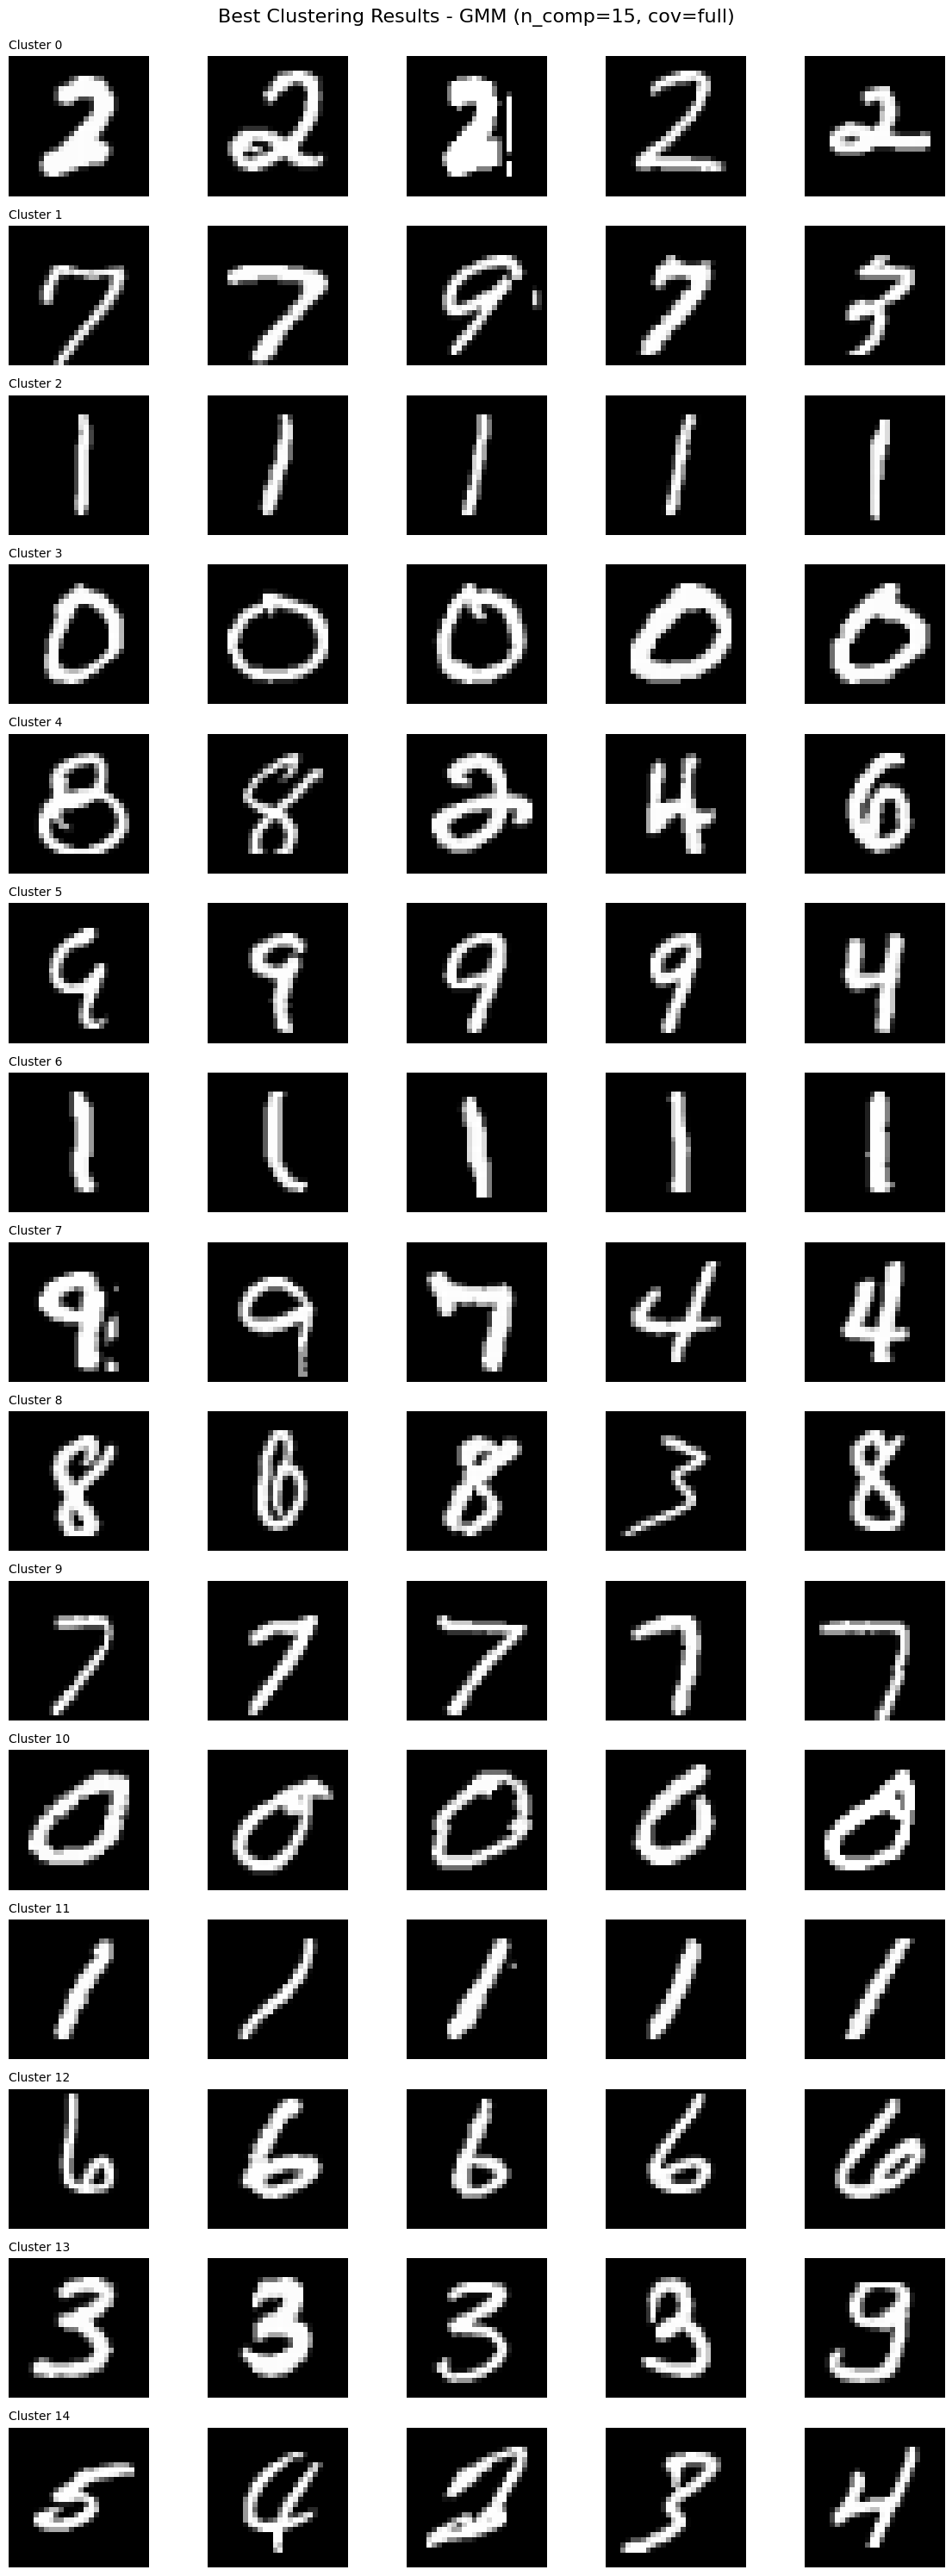

In [58]:
# 7. clustering results visualization

# best model
if best_kmeans['NMI'] > best_gmm['NMI']:
    best_model = best_kmeans
    best_labels = best_kmeans['labels']
    model_name = f"K-Means (K={best_kmeans['n_clusters']}, init={best_kmeans['init']})"
else:
    best_model = best_gmm
    best_labels = best_gmm['labels']
    model_name = f"GMM (n_comp={best_gmm['n_components']}, cov={best_gmm['covariance_type']})"


num_per_cluster = 5
title = f"Best Clustering Results - {model_name}"

n_clusters = len(np.unique(best_labels))
fig, axes = plt.subplots(n_clusters, num_per_cluster, figsize=(12, 2 * n_clusters))
fig.suptitle(title, fontsize=16, y=0.995)

for cluster_id in range(n_clusters):
    # get indices
    cluster_indices = np.where(best_labels == cluster_id)[0]

    # use all samples if not enough
    c_samples = min(num_per_cluster, len(cluster_indices))
    selected_indices = np.random.choice(cluster_indices, c_samples, replace=False)

    for i in range(num_per_cluster):
        if n_clusters == 1:
            ax = axes[i]
        else:
            ax = axes[cluster_id, i]

        if i < c_samples:
            idx = selected_indices[i]
            img = X[idx].reshape(28, 28)
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            if i == 0:
                ax.set_title(f'Cluster {cluster_id}', loc='left', fontsize=10)
        else:
            ax.axis('off')

plt.tight_layout()
plt.show()

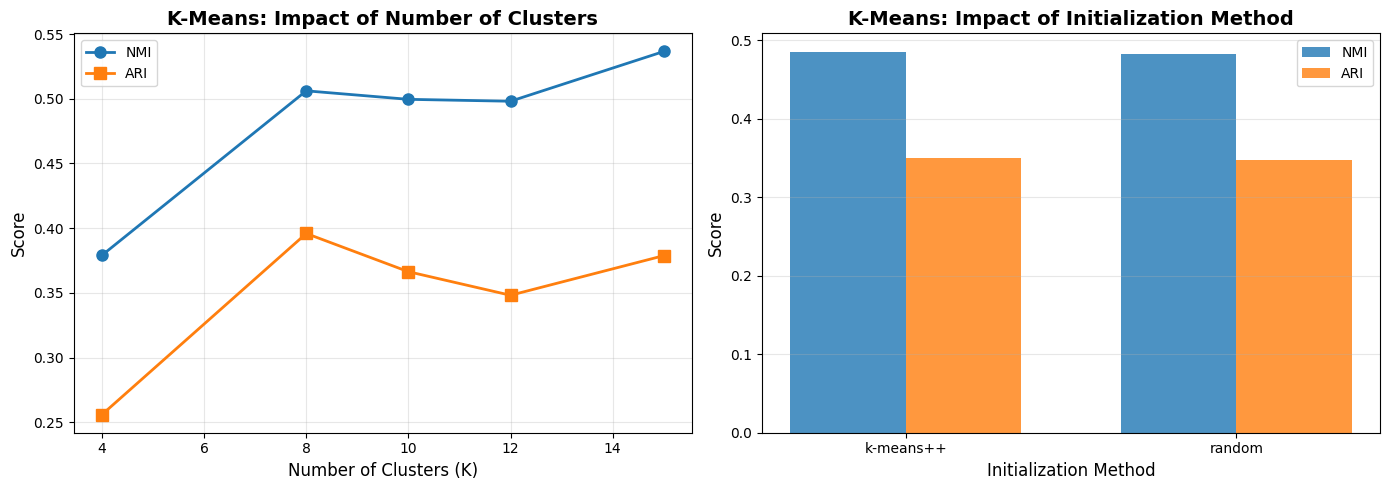

In [59]:
# 8. hyperparameter impact visualization

# k-means
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# number of clustering
kmeans_by_k = {}
for result in kmeans_results:
    k = result['n_clusters']
    if k not in kmeans_by_k:
        kmeans_by_k[k] = {'ARI': [], 'NMI': [], 'Silhouette': []}
    kmeans_by_k[k]['ARI'].append(result['ARI'])
    kmeans_by_k[k]['NMI'].append(result['NMI'])
    kmeans_by_k[k]['Silhouette'].append(result['Silhouette'])

k_values = sorted(kmeans_by_k.keys())
nmi_means = [np.mean(kmeans_by_k[k]['NMI']) for k in k_values]
ari_means = [np.mean(kmeans_by_k[k]['ARI']) for k in k_values]

axes[0].plot(k_values, nmi_means, 'o-', label='NMI', linewidth=2, markersize=8)
axes[0].plot(k_values, ari_means, 's-', label='ARI', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('K-Means: Impact of Number of Clusters', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# inital method
init_methods = ['k-means++', 'random']
init_comparison = {method: {'NMI': [], 'ARI': []} for method in init_methods}
for result in kmeans_results:
    init_comparison[result['init']]['NMI'].append(result['NMI'])
    init_comparison[result['init']]['ARI'].append(result['ARI'])

x_pos = np.arange(len(init_methods))
nmi_vals = [np.mean(init_comparison[m]['NMI']) for m in init_methods]
ari_vals = [np.mean(init_comparison[m]['ARI']) for m in init_methods]

width = 0.35
axes[1].bar(x_pos - width/2, nmi_vals, width, label='NMI', alpha=0.8)
axes[1].bar(x_pos + width/2, ari_vals, width, label='ARI', alpha=0.8)
axes[1].set_xlabel('Initialization Method', fontsize=12)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('K-Means: Impact of Initialization Method', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(init_methods)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

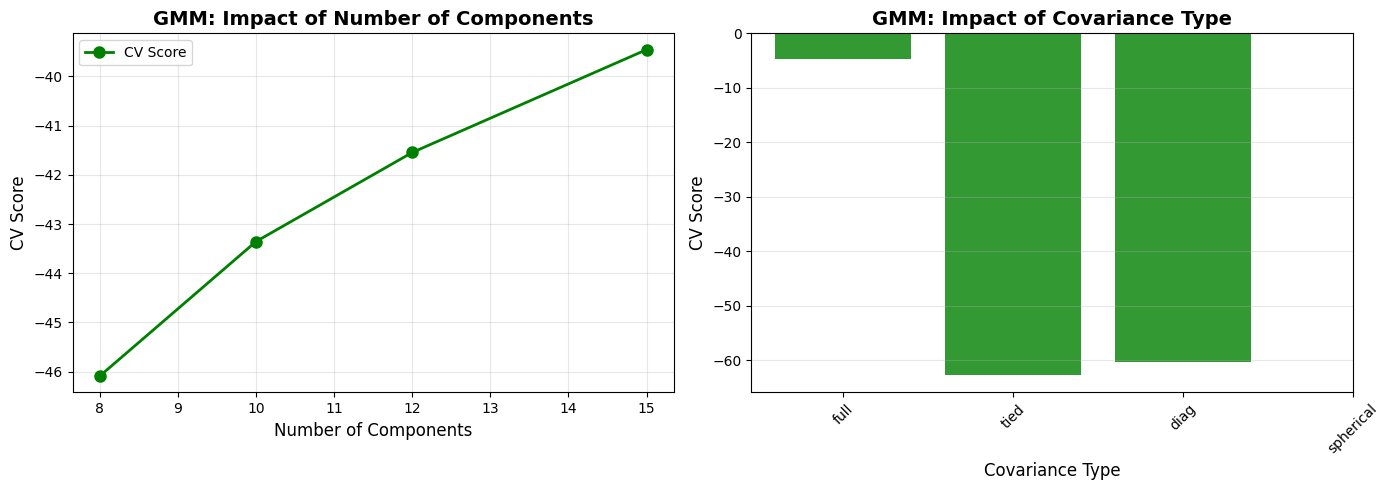

In [60]:
# gmm
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# number of components -- CV sscore
gmm_by_comp = {}
for i, params in enumerate(gmm_cv.cv_results_['params']):
    n_comp = params['n_components']
    if n_comp not in gmm_by_comp:
        gmm_by_comp[n_comp] = []
    gmm_by_comp[n_comp].append(gmm_cv.cv_results_['mean_test_score'][i])

comp_values = sorted(gmm_by_comp.keys())
cv_score_means = [np.mean(gmm_by_comp[c]) for c in comp_values]

axes[0].plot(comp_values, cv_score_means, 'o-', label='CV Score', 
             linewidth=2, markersize=8, color='green')
axes[0].set_xlabel('Number of Components', fontsize=12)
axes[0].set_ylabel('CV Score', fontsize=12)
axes[0].set_title('GMM: Impact of Number of Components', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# covariance type --- CV score
cov_types = ['full', 'tied', 'diag', 'spherical']
cov_comparison = {cov: [] for cov in cov_types}
for i, params in enumerate(gmm_cv.cv_results_['params']):
    cov_type = params['covariance_type']
    cov_comparison[cov_type].append(gmm_cv.cv_results_['mean_test_score'][i])

x_pos = np.arange(len(cov_types))
cv_vals = [np.mean(cov_comparison[c]) for c in cov_types]

axes[1].bar(x_pos, cv_vals, alpha=0.8, color='green')
axes[1].set_xlabel('Covariance Type', fontsize=12)
axes[1].set_ylabel('CV Score', fontsize=12)
axes[1].set_title('GMM: Impact of Covariance Type', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(cov_types, rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()